### Download COCO JSON file of Sunflower Dataset


In [1]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
# project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
# version = project.version(1)
# dataset = version.download("coco")
                
                

### Install ultralytics supervision and Roboflow. Then check for the CUDA

In [2]:
!pip install ultralytics --no-deps
import ultralytics
ultralytics.checks()

Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6562.9/8062.4 GB disk)


In [3]:
!pip install pycocotools tqdm


In [4]:
import os
import shutil
import json
from pathlib import Path
import yaml
from ultralytics import YOLO

In [5]:
# !pip install --quiet --upgrade numpy==1.25.2 scipy==1.10.1 scikit-learn==1.3.2 ultralytics pyyaml pandas matplotlib opencv-python


### Convert Train, Test, Val data from COCO to YOLO format

In [6]:
import json
import shutil
from pathlib import Path

# ----------------------------------------------------------------------------
# 0. Paths & COCO→YOLO conversion
# ----------------------------------------------------------------------------

# Update these paths based on your local system
COCO_ROOT     = Path("/kaggle/input/sunflower/Final-1")  # folder containing train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"

WORK          = Path("/kaggle/working/New_Converted_Dataset")  # output directory (can rename)

# Create output directory structure
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        (WORK / split / sub).mkdir(parents=True, exist_ok=True)

# Function to convert COCO bbox to YOLO format
def coco2yolo(box, w, h):
    x, y, w_box, h_box = box
    return ((x + w_box/2) / w, (y + h_box/2) / h, w_box / w, h_box / h)

# Convert one split from COCO to YOLO format
def convert(split, img_dir, ann_file, out_dir):
    with open(ann_file, "r") as f:
        coco = json.load(f)

    id2img = {img["id"]: img for img in coco["images"]}
    imgs_o = out_dir / split / "images"
    labs_o = out_dir / split / "labels"

    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        yolo_box = coco2yolo(ann["bbox"], img["width"], img["height"])
        cls = ann["category_id"] - 1  # Class index starts from 0 in YOLO
        label_path = labs_o / f"{Path(img['file_name']).stem}.txt"
        with open(label_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yolo_box) + "\n")

    for img in coco["images"]:
        shutil.copy(img_dir / img["file_name"], imgs_o / img["file_name"])

# ----------------------------------------------------------------------------
# 1. Perform Conversion
# ----------------------------------------------------------------------------
convert("train", TRAIN_IMG_DIR, TRAIN_ANN, WORK)
convert("valid", VAL_IMG_DIR,   VAL_ANN,   WORK)
convert("test",  TRAIN_IMG_DIR, TRAIN_ANN, WORK)  # Optional test reuse


### Visualize Some Annotated images

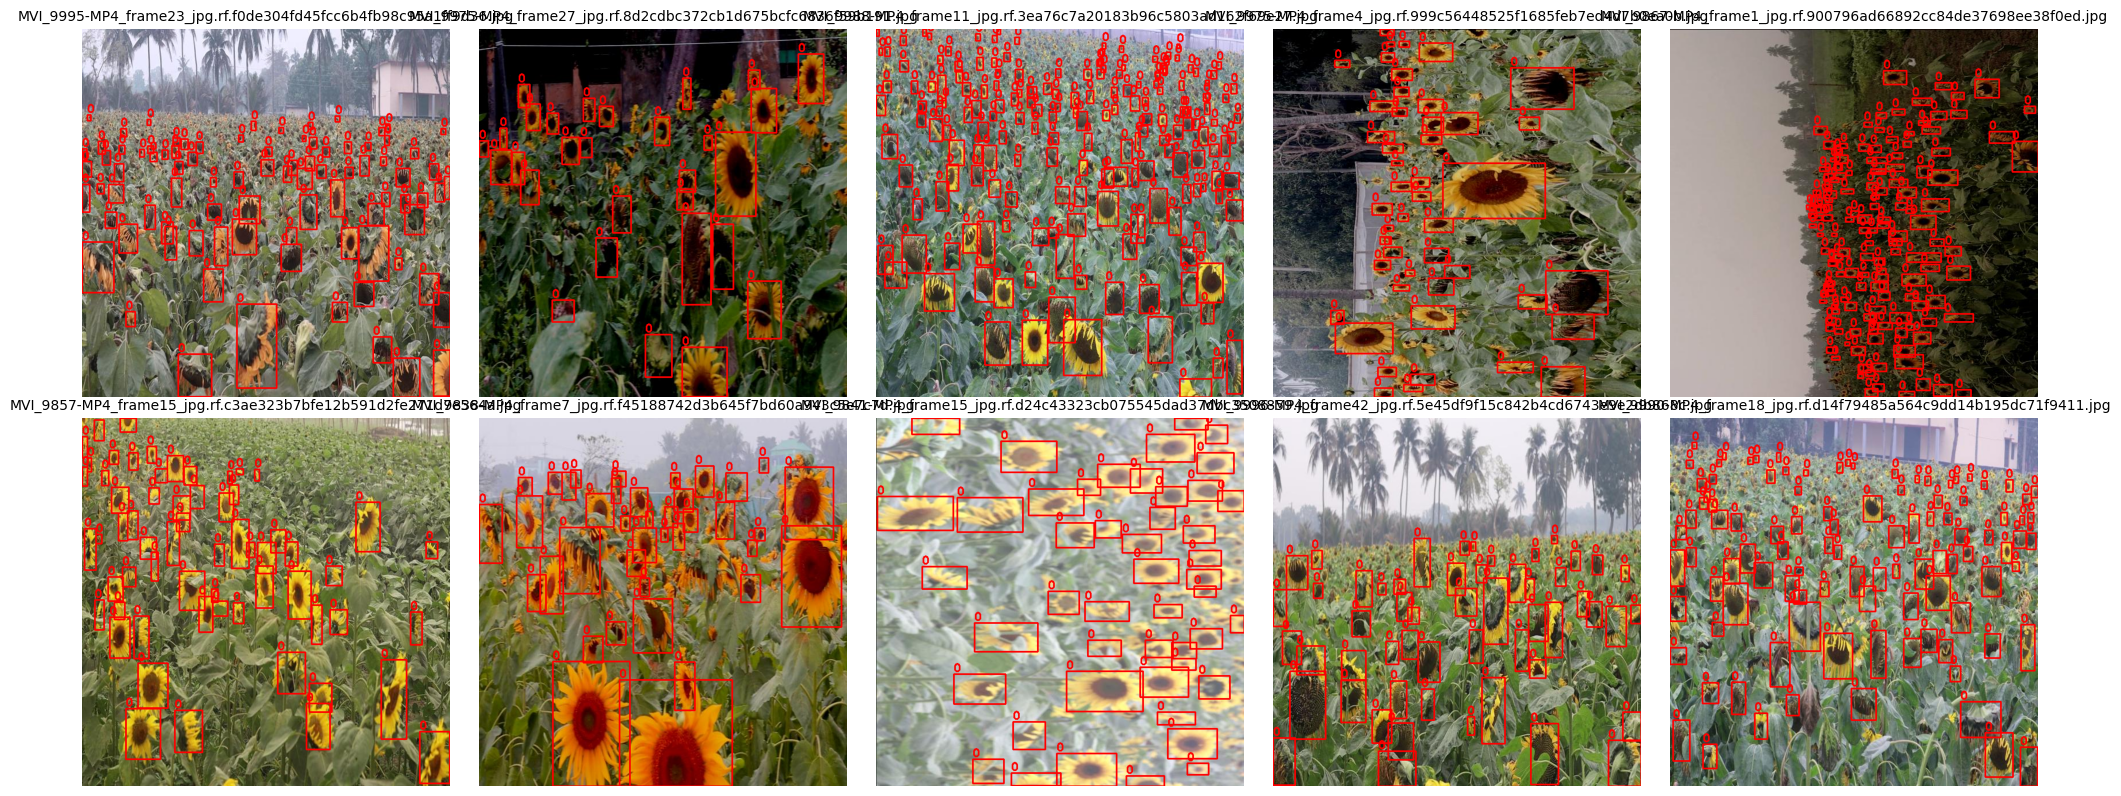

In [7]:
import cv2
import matplotlib.pyplot as plt
import random

# ----------------------------------------------------------------------------
# 2. Visualize Converted YOLO Annotations
# ----------------------------------------------------------------------------

def draw_yolo_bbox(img_path, label_path):
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    if not label_path.exists():
        return image  # No label file

    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x_c, y_c, bw, bh = map(float, line.strip().split())
            x1 = int((x_c - bw / 2) * w)
            y1 = int((y_c - bh / 2) * h)
            x2 = int((x_c + bw / 2) * w)
            y2 = int((y_c + bh / 2) * h)
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(image, str(int(cls)), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    return image

# Pick 10 random images from the converted train split
img_dir = WORK / "train" / "images"
lbl_dir = WORK / "train" / "labels"
img_files = list(img_dir.glob("*.jpg"))
sample_files = random.sample(img_files, min(10, len(img_files)))

# Plot 2 rows of 5 images
plt.figure(figsize=(20, 8))
for idx, img_path in enumerate(sample_files):
    label_path = lbl_dir / f"{img_path.stem}.txt"
    img = draw_yolo_bbox(img_path, label_path)
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_path.name, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
# ----------------------------------------------------------------------------
# 1. Write data YAML
# ----------------------------------------------------------------------------
import yaml

cats  = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
data_cfg = {
    "path":  str(WORK),
    "train": "train/images",
    "val":   "valid/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names
}
(WORK/"data_Sunflower.yaml").write_text(yaml.dump(data_cfg))

137

In [9]:
!pip install --quiet --upgrade numpy==1.25.2 scipy==1.10.1 scikit-learn==1.3.2
!pip install ultralytics --no-deps
import ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 96.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.226 requires ultralytics-thop>=2.0.18, which is not installed.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.25.2 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.25.2 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.25.2 which is incompatible.
datasets 4.1.1 requires pyarrow>=21.0.0, bu

In [10]:
# ================= Kaggle-compatible Full K-Fold YOLOv12 Training =================

import os
import shutil
from pathlib import Path
from sklearn.model_selection import KFold
from ultralytics import YOLO
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1. Paths & Hyperparameters
# ----------------------------------------------------------------------------
# WORK = Path("/kaggle/working/New_Converted_Dataset")  # Kaggle-compatible working path
WORK.mkdir(parents=True, exist_ok=True)

YAML_PATH = WORK / "data_Sunflower.yaml"
K_FOLDS = 5
EPOCHS = 50
BATCH_SIZE = 12
IMG_SIZE = 640

# ----------------------------------------------------------------------------
# 2. Load dataset info
# ----------------------------------------------------------------------------
with open(YAML_PATH, "r") as f:
    data_yaml = yaml.safe_load(f)

# Remove duplicate class names
if isinstance(data_yaml.get("names"), list):
    data_yaml["names"] = list(dict.fromkeys(data_yaml["names"]))
data_yaml["nc"] = len(data_yaml["names"])

# Recursively find all images
image_dir = Path(data_yaml["path"])
all_images = sorted(
    [str(p) for p in image_dir.glob("**/images/*.jpg")] +
    [str(p) for p in image_dir.glob("**/images/*.png")]
)

print(f"✅ Total images found: {len(all_images)}")
if len(all_images) == 0:
    raise ValueError("❌ No images found. Check 'path' in YAML and folder structure.")

# ----------------------------------------------------------------------------
# 2A. Cleanup old folds (optional, prevents SameFileError)
# ----------------------------------------------------------------------------
for i in range(1, K_FOLDS+1):
    fold_path = WORK / f"fold_{i}"
    if fold_path.exists():
        shutil.rmtree(fold_path)

# ----------------------------------------------------------------------------
# 3. KFold setup
# ----------------------------------------------------------------------------
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_metrics = {"Fold": [], "mAP50": [], "mAP50-95": [], "Precision": [], "Recall": []}
best_overall_score = -1.0
best_overall_weights = None

# ----------------------------------------------------------------------------
# 4. Training loop
# ----------------------------------------------------------------------------
for fold, (train_idx, val_idx) in enumerate(kf.split(all_images)):
    print(f"\n🚀 === Fold {fold+1}/{K_FOLDS} ===")

    fold_dir = WORK / f"fold_{fold+1}"
    fold_dir.mkdir(parents=True, exist_ok=True)

    train_images = [all_images[i] for i in train_idx]
    val_images   = [all_images[i] for i in val_idx]

    # ----------------- 4A. Create YOLO dataset structure -----------------
    def make_split(images, split_name):
        split_img_dir = fold_dir / split_name / "images"
        split_lbl_dir = fold_dir / split_name / "labels"
        split_img_dir.mkdir(parents=True, exist_ok=True)
        split_lbl_dir.mkdir(parents=True, exist_ok=True)

        for img_path in images:
            img_path = Path(img_path)
            dst_img_path = split_img_dir / img_path.name

            # Skip if source and destination are the same
            if img_path.resolve() == dst_img_path.resolve():
                continue

            # Copy image
            shutil.copy(img_path, dst_img_path)

            # Copy label
            try:
                # Compute label path relative to original dataset
                relative_parts = img_path.parts[len(Path(data_yaml["path"]).parts):]
                lbl_path = Path(data_yaml["path"]).joinpath(*relative_parts).with_suffix(".txt")
                lbl_path = Path(str(lbl_path).replace("images", "labels"))
                dst_lbl_path = split_lbl_dir / lbl_path.name

                if lbl_path.exists() and lbl_path.resolve() != dst_lbl_path.resolve():
                    shutil.copy(lbl_path, dst_lbl_path)
                elif not lbl_path.exists():
                    print(f"⚠️ Label not found for {img_path.name}, skipping label.")
            except Exception as e:
                print(f"⚠️ Error copying label for {img_path.name}: {e}")

    make_split(train_images, "train")
    make_split(val_images, "val")

    # ----------------- 4B. Write YAML for this fold -----------------
    fold_yaml = fold_dir / f"data_fold{fold+1}.yaml"
    yaml_data = {
        "path": str(fold_dir),
        "train": "train/images",
        "val": "val/images",
        "names": data_yaml["names"]
    }
    with open(fold_yaml, "w") as f:
        yaml.dump(yaml_data, f)

    # ----------------- 4C. Train YOLOv12 -----------------
    model = YOLO("yolo12s.pt")
    results = model.train(
        data=str(fold_yaml),
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        val=True,
        save_json=True,
        project=str(WORK / "kfold_results"),
        name=f"yolov12_fold{fold+1}",
        device=0,
        verbose=False,
        save=True,
        exist_ok=True
    )

    run_dir = Path(results.save_dir)
    results_csv = run_dir / "results.csv"
    best_weights = run_dir / "weights" / "best.pt"

    if not best_weights.exists():
        print(f"⚠️ No best.pt found for fold {fold+1}, skipping.")
        continue

    # ----------------- 4D. Extract validation metrics -----------------
    try:
        metrics_dict = getattr(results, "results_dict", None) or getattr(results, "metrics", {}) or {}

        mAP50_95 = metrics_dict.get("metrics/mAP50-95(B)", np.nan)
        mAP50    = metrics_dict.get("metrics/mAP50(B)", np.nan)
        prec     = metrics_dict.get("metrics/precision(B)", np.nan)
        rec      = metrics_dict.get("metrics/recall(B)", np.nan)

        # Alternate keys
        if np.isnan(mAP50_95) and "map50-95" in metrics_dict:
            mAP50_95 = metrics_dict["map50-95"]
        if np.isnan(mAP50) and "map50" in metrics_dict:
            mAP50 = metrics_dict["map50"]
        if np.isnan(prec) and "precision" in metrics_dict:
            prec = metrics_dict["precision"]
        if np.isnan(rec) and "recall" in metrics_dict:
            rec = metrics_dict["recall"]

    except Exception as e:
        print(f"⚠️ Error reading metrics for fold {fold+1}: {e}")
        mAP50_95, mAP50, prec, rec = np.nan, np.nan, np.nan, np.nan

    fold_metrics["Fold"].append(fold + 1)
    fold_metrics["mAP50"].append(mAP50)
    fold_metrics["mAP50-95"].append(mAP50_95)
    fold_metrics["Precision"].append(prec)
    fold_metrics["Recall"].append(rec)

    # ----------------- 4E. Plot training & validation loss -----------------
    if results_csv.exists():
        df = pd.read_csv(results_csv)
        for col in ["train/box_loss", "train/cls_loss", "val/box_loss", "val/cls_loss"]:
            if col not in df.columns:
                df[col] = np.nan
        plt.figure(figsize=(8, 5))
        plt.plot(df["epoch"], df["train/box_loss"], label="Train Box", color="#1f77b4")
        plt.plot(df["epoch"], df["train/cls_loss"], label="Train Cls", color="#ff7f0e")
        plt.plot(df["epoch"], df["val/box_loss"], label="Val Box", color="#2ca02c")
        plt.plot(df["epoch"], df["val/cls_loss"], label="Val Cls", color="#d62728")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Training & Validation Loss - Fold {fold+1}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(WORK / f"loss_curve_fold{fold+1}.png")
        plt.close()

    # ----------------- 4F. Track best model -----------------
    if mAP50_95 > best_overall_score:
        best_overall_score = mAP50_95
        best_overall_weights = best_weights
        print(f"🌟 New best model at Fold {fold+1} with mAP50-95 = {mAP50_95:.4f}")

# ----------------- 5. Save final best model -----------------
if best_overall_weights and best_overall_weights.exists():
    final_path = WORK / "best_overall.pt"
    shutil.copy(best_overall_weights, final_path)
    print(f"\n✅ Final best model saved: {final_path} (mAP50-95 = {best_overall_score:.4f})")
else:
    print("\n⚠️ No best weights found.")

# ----------------- 6. Compute mean ± std metrics -----------------
metrics_df = pd.DataFrame(fold_metrics)
mean_metrics = metrics_df.mean(numeric_only=True)
std_metrics  = metrics_df.std(numeric_only=True)

summary_df = pd.DataFrame({
    "Mean": mean_metrics,
    "Std": std_metrics,
    "Mean ± Std": [f"{mean_metrics[i]:.4f} ± {std_metrics[i]:.4f}" for i in mean_metrics.index]
})

print("\n📊 === K-Fold Evaluation Summary (YOLOv12) ===")
print(summary_df)

# ----------------- 7. Save fold metrics CSV -----------------
results_dir = WORK / "kfold_results"
results_dir.mkdir(exist_ok=True)
summary_path = results_dir / "kfold_summary.csv"
metrics_df.to_csv(summary_path, index=False)
print(f"\n📝 Detailed fold metrics saved to: {summary_path}")


✅ Total images found: 8079

🚀 === Fold 1/5 ===
Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/New_Converted_Dataset/fold_1/data_fold1.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov12_fold1, nbs=64, nms=False, opset=None, optimize=False, o

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1448     117301      0.875      0.852      0.927      0.612
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Saving /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold1/predictions.json...
Results saved to /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold1
🌟 New best model at Fold 1 with mAP50-95 = 0.6116

🚀 === Fold 2/5 ===
Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/New_Converted_Dataset/fold_2/data_fold2.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1464     119954      0.873      0.855      0.928      0.612
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Saving /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold2/predictions.json...
Results saved to /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold2
🌟 New best model at Fold 2 with mAP50-95 = 0.6124

🚀 === Fold 3/5 ===
Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/New_Converted_Dataset/fold_3/data_fold3.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1447     121502      0.877      0.858      0.932      0.618
Speed: 0.2ms preprocess, 10.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Saving /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold3/predictions.json...
Results saved to /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold3
🌟 New best model at Fold 3 with mAP50-95 = 0.6179

🚀 === Fold 4/5 ===
Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/New_Converted_Dataset/fold_4/data_fold4.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1484     122276      0.875      0.845      0.919      0.606
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Saving /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold4/predictions.json...
Results saved to /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold4

🚀 === Fold 5/5 ===
Ultralytics 8.3.226 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/New_Converted_Dataset/fold_5/data_fold5.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, ha

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1456     122722      0.879      0.856      0.931      0.616
Speed: 0.2ms preprocess, 12.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Saving /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold5/predictions.json...
Results saved to /kaggle/working/New_Converted_Dataset/kfold_results/yolov12_fold5

✅ Final best model saved: /kaggle/working/New_Converted_Dataset/best_overall.pt (mAP50-95 = 0.6179)

📊 === K-Fold Evaluation Summary (YOLOv12) ===
               Mean       Std       Mean ± Std
Fold       3.000000  1.581139  3.0000 ± 1.5811
mAP50      0.927410  0.005002  0.9274 ± 0.0050
mAP50-95   0.612702  0.004501  0.6127 ± 0.0045
Precision  0.875707  0.002320  0.8757 ± 0.0023
Recall     0.853360  0.005128  0.8534 ± 0.0051

📝 Detailed fold metrics saved to: /kaggle/working/New_Converted_Dataset/kfold_results/kfold_summary.csv


In [11]:
print(type(fold_metrics))
for i, item in enumerate(fold_metrics):
    print(i, type(item), item)
    if i == 3: break   # show first 4 only


<class 'dict'>
0 <class 'str'> Fold
1 <class 'str'> mAP50
2 <class 'str'> mAP50-95
3 <class 'str'> Precision


In [12]:
# ----------------- 6. Compute mean ± std metrics -----------------
# Convert dict-of-lists → DataFrame
metrics_df = pd.DataFrame.from_dict(fold_metrics).fillna(0)

mean_metrics = metrics_df.mean(numeric_only=True)
std_metrics  = metrics_df.std(numeric_only=True)

summary_df = pd.DataFrame({
    "Mean": mean_metrics,
    "Std": std_metrics,
    "Mean ± Std": [f"{mean_metrics[i]:.4f} ± {std_metrics[i]:.4f}" for i in mean_metrics.index]
})

print("\n📊 === K-Fold Evaluation Summary (YOLOv12) ===")
print(summary_df)

# ----------------- 7. Save fold metrics CSV -----------------
results_dir = WORK / "kfold_results"
results_dir.mkdir(exist_ok=True)
summary_path = results_dir / "kfold_summary.csv"
metrics_df.to_csv(summary_path, index=False)
print(f"\n📝 Detailed fold metrics saved to: {summary_path}")



📊 === K-Fold Evaluation Summary (YOLOv12) ===
               Mean       Std       Mean ± Std
Fold       3.000000  1.581139  3.0000 ± 1.5811
mAP50      0.927410  0.005002  0.9274 ± 0.0050
mAP50-95   0.612702  0.004501  0.6127 ± 0.0045
Precision  0.875707  0.002320  0.8757 ± 0.0023
Recall     0.853360  0.005128  0.8534 ± 0.0051

📝 Detailed fold metrics saved to: /kaggle/working/New_Converted_Dataset/kfold_results/kfold_summary.csv


### XAI

In [13]:
!git clone https://github.com/rigvedrs/YOLO-V12-CAM.git

Cloning into 'YOLO-V12-CAM'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 168 (delta 39), reused 21 (delta 11), pack-reused 99 (from 2)
Receiving objects: 100% (168/168), 52.67 MiB | 38.22 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [14]:
!ls

New_Converted_Dataset  __notebook__.ipynb  yolo11n.pt  yolo12s.pt  YOLO-V12-CAM


In [15]:
!pip install ttach

import sys
sys.path.append("/kaggle/working/YOLO-V12-CAM")
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [16]:
import cv2
import numpy as np
model = YOLO( run_dir /'weights/best.pt')
model = model.cpu()

In [17]:
img = cv2.imread('/kaggle/working/New_Converted_Dataset/test/images/20240116_122814-mp4_frame13_jpg.rf.18c1203e57aa96382736c7dd69aa7c12.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [18]:
target_layers =[model.model.model[-2]]

RGB


0: 640x640 147 Sunflowers, 337.5ms
Speed: 10.1ms preprocess, 337.5ms inference, 34.1ms postprocess per image at shape (1, 3, 640, 640)


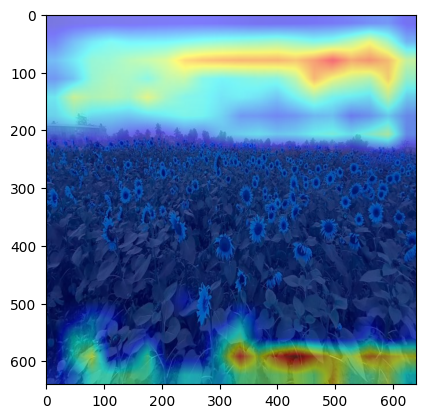

In [19]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

GrayScale

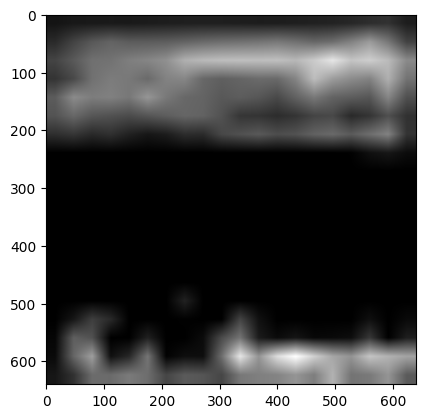

In [20]:
import matplotlib.pyplot as plt
import numpy as np
g_scale = np.stack([grayscale_cam] * 3, axis=2)
plt.imshow(g_scale)

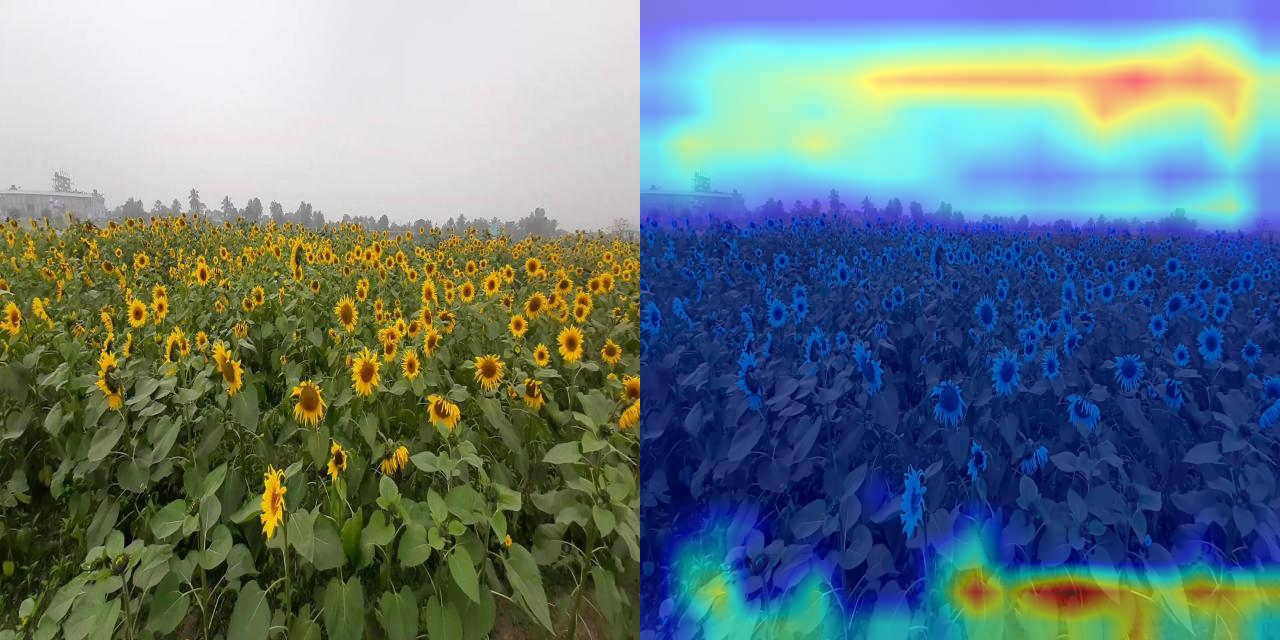

In [21]:
import cv2
from PIL import Image
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

Model has 22 layers.
Using target layers at indices: [19, 20, 21]

0: 640x640 (no detections), 296.1ms
Speed: 3.5ms preprocess, 296.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


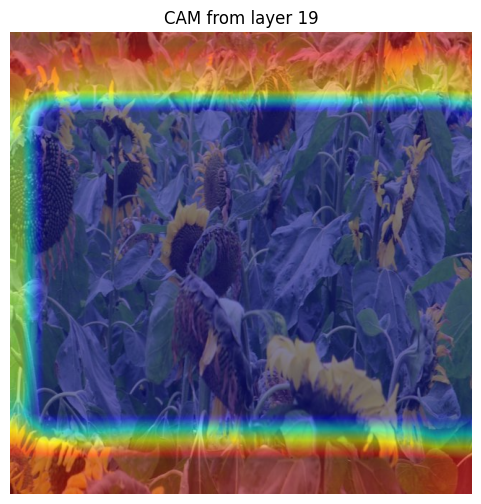


0: 640x640 (no detections), 256.6ms
Speed: 3.3ms preprocess, 256.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


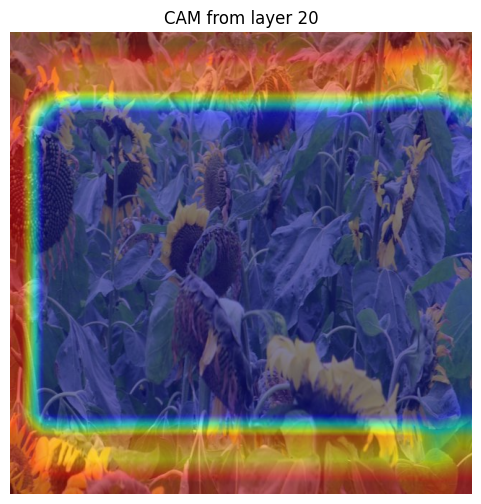


0: 640x640 (no detections), 240.8ms
Speed: 3.3ms preprocess, 240.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


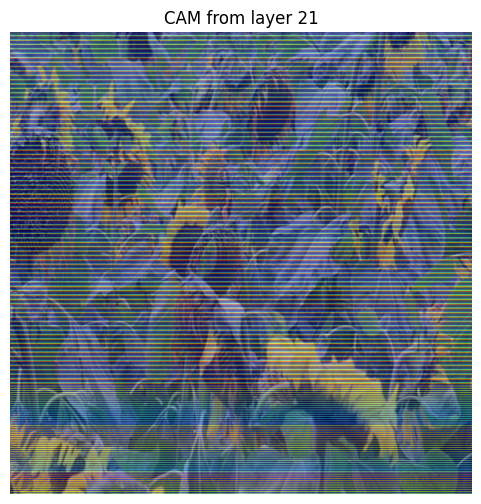


0: 640x640 15 Sunflowers, 245.6ms
Speed: 2.2ms preprocess, 245.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


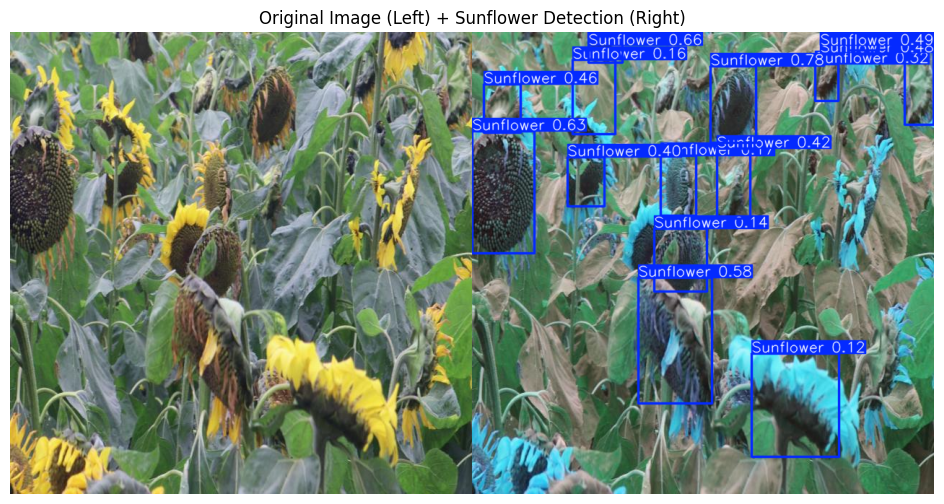

In [22]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image

def doMultiScaleCAM(modelPath, imagePath, modelIndexes=None):
    # Load YOLO model on CPU
    model = YOLO(modelPath)
    model = model.cpu()

    # Read image
    img = cv2.imread(imagePath)
    if img is None:
        raise FileNotFoundError(f"Image not found: {imagePath}")

    img = cv2.resize(img, (640, 640))

    # Convert BGR -> RGB for CAM
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_norm = np.float32(rgb_img) / 255.0

    total_layers = len(model.model.model)
    print(f"Model has {total_layers} layers.")

    # Default last 3 layers if none provided
    if modelIndexes is None:
        modelIndexes = [total_layers - 3, total_layers - 2, total_layers - 1]
    else:
        modelIndexes = [i for i in modelIndexes if 0 <= i < total_layers]

    print(f"Using target layers at indices: {modelIndexes}")

    # Handle tuple outputs in CAM
    def reshape_transform(tensor_or_tuple):
        if isinstance(tensor_or_tuple, tuple):
            return tensor_or_tuple[0]
        return tensor_or_tuple

    # Generate CAMs
    for i in modelIndexes:
        target_layers = [model.model.model[i]]
        cam = EigenCAM(model, target_layers, task='od', reshape_transform=reshape_transform)
        grayscale_cam = cam(img_norm)[0, :, :]
        cam_image = show_cam_on_image(img_norm, grayscale_cam, use_rgb=True)
        plt.figure(figsize=(6, 6))
        plt.imshow(cam_image)
        plt.axis('off')
        plt.title(f'CAM from layer {i}')
        plt.show()

    # Run detection on RGB image
    results = model(rgb_img, conf=0.1, iou=0.4)[0]

    # Filter sunflower class (class_id 0)
    sunflower_class_id = 0  # adjust if needed
    filtered_boxes = [box for box in results.boxes if int(box.cls.item()) == sunflower_class_id]
    results.boxes = filtered_boxes

    # Plot filtered detection
    res_img = cv2.cvtColor(results.plot(), cv2.COLOR_BGR2RGB)

    # Combine original and result images horizontally
    combined = np.hstack((rgb_img, res_img))

    # Display inline
    plt.figure(figsize=(12, 6))
    plt.imshow(combined)
    plt.axis('off')
    plt.title("Original Image (Left) + Sunflower Detection (Right)")
    plt.show()

    return Image.fromarray(combined)


# ================= Usage Example =================
result_img = doMultiScaleCAM(
    str(run_dir/"weights/best.pt"),
    "/kaggle/working/New_Converted_Dataset/test/images/MVI_9999-MP4_frame5_jpg.rf.52d4f7f3c176edef8832481f756c2b67.jpg"
)
